# 引言

### 研究目的
本文参考方正证券《A股“跳一跳”：隔夜跳空选股因子》，采用研报内的方法对隔夜跳空因子进行研究。根据研报分析，选股上隔夜涨跌幅既不呈现反转也不呈现动量，过大或者过小在后一月都具有负向收益，因此引入隔夜涨跌幅的绝对值来衡量这种隔夜跳空异动的现象。从技术形态上解释，涨跌幅的绝对值可以理解为跳空缺口，是K线图中常见的一种技术图形。俗话说“跳空缺口，逢缺必补”，古老技术分析的经验，和研究结论是一致的。从交易行为解释，跳空缺口的形成其实是短期激进的交易行为导致的。开盘价格异动，和集合竞价成交占比提高、换手率提升、股价抬高、成交量相对价格抢跑等特征一样，都反映了股市短期的股价操纵行为。 

根据此结论，本文对研报里面的结果进行了分析，并对股票隔夜价格变动进行了研究，从其中提取出 alpha 因子，从而实现对股票未来收益的预测。

### 研究内容
本文的研究始于隔夜涨跌幅，该指标衡量今日开盘价与昨日收盘价之间的变化。总体来看，开盘价与收盘价是一天最为重要的两个时间截点，多空双方在这两个关键时点上的博弈最激烈，信息含量最大。按照这个思路，展开研究：

1）我们取每个股票过去 10 个交易日的隔夜涨跌幅平均值来作为研究对象，为构建因子提供思路 

2）构建了跳空因子，只考虑价格的绝对变动水平。通过分层回测、多空组合等多种方式分析因子的有效性。测试时段： 2016 年 6 月-2018 年 12 月（剔除成分股内上市未满6个月的股票）；样本空间： 全A股； 调仓方式： 在每个月底，将各股票按总得分排序，划分为五组， 分别持有至下个月月末；得分最高的组合为多头组合，得分最低的组合为空头组合

3）常用因子相关性检验：市值、 动量和换手作为已知的有效常用因子，可能会对新挖掘的因子有一定的影响。 我们对其进行检验

4） 因子变形：因子可能的一个变形是计算个股开盘涨跌幅与均值的距离替代与 0 的距离，这个变形考虑到受市场行情影响，股票可能会有系统性的高开或者低开的情况。并对变形后的因子进行测试

5） 因子在指数上的表现：因子在沪深300和中证500的表现
### 研究结论
1）隔夜无论价格变动方向如何， 变动绝对值越大的个股在未来收益越不理想，按月换仓，持有变动值最大分组在回测区间平均年化收益为-25%。

2）隔夜价格变动因子有着显著的区分作用，在全A股范围内多空净值曲线的年化均超过了20%，最大回撤控制在了7%以内，卡玛比超过3.

3）随着回看时间的拉长，隔夜涨跌幅这种性质逐渐减弱， 因子的预测能力时间上衰减较快。回看期窗口为10天最优，小于10天噪声太大，偶然性太高，若回看窗口为60天，120天，则分组效果不明显。

因子结果展示：
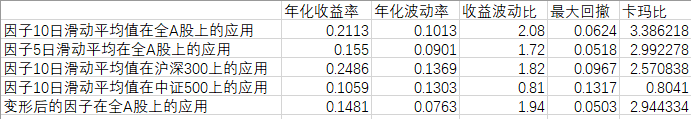



In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/19226
# 标题：开盘跳空是否透露超额收益？A股跳一跳因子挖掘

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jqdata import *
import math
import matplotlib.dates as mdate
from  datetime import datetime,timedelta
from scipy.stats import spearmanr

## 1.数据获取
股票池: 全A股
股票筛选：剔除上市 6 个月内的股票，每只股票视作一个样本，选取样本的区间在2016年6月到2018年12月

In [2]:
#去除上市距beginDate不足6个月的股票，剔除ST股，剔除停牌，退市等股票
def delect_stock(stocks,beginDate,n=180):
    #去除上市距beginDate不足6个月的股票
    stockList = []
    beginDate = datetime.strptime(beginDate, "%Y-%m-%d")
    for stock in stocks:
        start_date = get_security_info(stock).start_date
        if start_date < (beginDate-timedelta(days = n)).date():
            stockList.append(stock)
    #剔除ST股
    st_data = get_extras('is_st', stockList, count = 1, end_date=beginDate)
    stockList = [stock for stock in stockList if not st_data[stock][0]]
    return stockList
#获取数据，构建隔夜跳变百分比因子，选取30日的隔夜股价跳变百分比的平均值作为研究对象
start, end = '2016-06-01', '2018-12-29'
#选取沪深300作为股票池代表A股市场
stocks = np.array(get_index_stocks('000001.XSHG'))
stocks = delect_stock(list(stocks),start)
data = get_price(stocks, start_date=start, end_date=end, frequency='daily', fields=None, skip_paused=False, fq='pre')


/opt/conda/lib/python3.6/site-packages/jqresearch/api.py:86: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  pre_factor_ref_date=_get_today())


提取数据后，首先我们选取每个股票过去 10 个交易日的隔夜涨跌幅平均值来作为研究对象。 

In [3]:
open = data.loc['open'].iloc[1:]
close = data.loc['close']
close_p = np.array(data.loc['close'].iloc[0:-1])
open_p = np.array(data.loc['open'].iloc[1:])
jump = pd.DataFrame(multiply(open_p,1/close_p) - 1,columns = open.columns,index = open.index)
#10日滑动平均.rolling(12).mean()
mv_jump = jump.rolling(10).mean().iloc[0:].fillna(0).iloc[10:]
print(mv_jump.head(5))

            600000.XSHG  600004.XSHG     ...       603997.XSHG  603998.XSHG
2016-06-20    -0.000432    -0.001657     ...         -0.003799    -0.003663
2016-06-21    -0.000767    -0.001655     ...         -0.003549    -0.002181
2016-06-22    -0.000934    -0.002160     ...         -0.003714    -0.002515
2016-06-23    -0.000677    -0.002287     ...         -0.003630    -0.001864
2016-06-24    -0.000763    -0.002665     ...         -0.003467    -0.001551

[5 rows x 1023 columns]


## 2.因子的描述
以2018年12月29日为例，下图给出的是10日（N=10）隔夜涨跌幅水平的分布直方图和描述性统计。

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


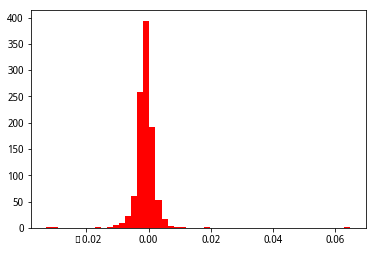

均值，标准差，偏度，峰度,中位数
[-0.0009873162159643348, 0.0036191457543669494, 4.66387594057111, 0.001576627966357079, -0.0019452926690520234]


In [4]:
import math
#描述性统计
def calc(data):
    n = len(data)
    niu = 0.0
    niu2 = 0.0
    niu3 = 0.0
    for a in data:
        niu += a
        niu2 += a**2
        niu3 += a**3
    niu/= n   #这是求E(X)
    niu2 /= n #这是E(X^2)
    niu3 /= n #这是E(X^3)
    sigma = math.sqrt(niu2 - niu*niu) #这是D（X）的开方，标准差
    return [niu,sigma,niu3] #返回[E（X）,标准差，E（X^3）]

def calc_stat(data):
    median = data[len(data)//2] if len(data)%2==1 else "%.1f"%(0.5*(data[len(data)//2-1]+data[len(data)//2]))
    [niu,sigma,niu3] = calc(data)
    n = len(data)
    niu4 = 0.0
    for a in data:
        a -= niu
        niu4 += a ** 4
    niu4 /= n   
    skew = (niu3 - 3*niu*sigma**2 - niu**3)/(sigma**3)
    kurt =  niu4/(sigma**2)
    return [niu,sigma,skew,kurt,median] #返回了均值，标准差，偏度，峰度，中位数
#画出隔夜涨跌幅水平的分布直方图
tem_jump = list(mv_jump.iloc[-1])
plt.hist(tem_jump, bins= 50, normed= False, weights= None, cumulative= False, 
         bottom= None, histtype= 'bar', align= 'mid', orientation= 'vertical', rwidth= None, log= False, color= 'r', 
         label='直方图', stacked= False)
plt.show()
print('均值，标准差，偏度，峰度,中位数')
print(calc_stat(tem_jump))

无论是直观的从分布直方图观测还是根据统计数值来看，数据均值为负，且集中度较高，主要集中在-0.001附近。这说明从隔夜涨跌幅来看，当天A股市场股票普遍小幅低开。
忽略时间维度，我们将 2016年6月至2018年12月的隔夜涨跌幅水平做相同的统计，结果如下。数据均值依然为负，且集中度更高，主要集中在-0.0013附近。符合单日的数据特性，低开占比高，且低开幅度较小，低开高走是A股股票的主要特点。

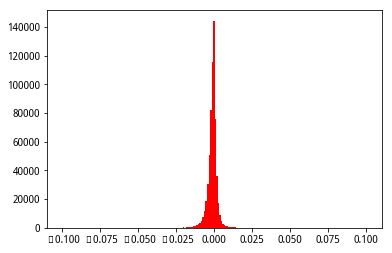

均值，标准差，偏度，峰度，中位数
[-0.001293757240125952, 0.0038389933448940887, -1.7054676361187229, 0.001026503983068225, '0.0']


In [5]:
#统计整个期间隔夜涨跌幅的分布情况
for i in range(0,len(mv_jump)-1):
    tem_jump.extend(list(mv_jump.iloc[i]))

plt.hist(tem_jump, bins= 200, normed= False, weights= None, cumulative= False, 
         bottom= None, histtype= 'bar', align= 'mid', orientation= 'vertical', rwidth= None, log= False, color= 'r', 
         label='直方图', stacked= False)
plt.show()
print('均值，标准差，偏度，峰度，中位数')
print(calc_stat(tem_jump))

为了观测隔夜涨跌幅水平与未来标的资产收益的关系，我们采用了分层回溯的方法，在每个月末将历史因子值排序后分为10组，然后观察每一组在回测期间的收益情况。回测时间段为2016年中至2018年12月中 。

In [6]:
#获取因子排名
def get_alpharank(alpha,date):
    alpha0=alpha.loc[date]
    t=pd.DataFrame(np.argsort(np.array(alpha0),axis=1),index=alpha0.index)
    return t  
mv_jump_monthly = mv_jump.resample('M').last()
alpharank = get_alpharank(mv_jump_monthly,mv_jump_monthly.index)
#评价指标
def report(ret,freqcy=1):
    ret.fillna(0,inplace=True)
    net = (1+ret).cumprod()
    yld_rate = (net.iloc[-1]/net.iloc[0]) ** (242/freqcy/len(net)) - 1 
    sigma = np.std(ret) * np.sqrt(242/freqcy) # 年化波动率
    sharpe = yld_rate / sigma # 夏普比 sharpe ratio
    drawdown = net/net.cummax() - 1 #回撤
    maxdrawdown = max(-drawdown[0])
    summary_table = pd.DataFrame(index=[0])
    summary_table["年化收益率"] = str(round(yld_rate[0]*100,2))+'%'
    summary_table["年化波动率"] = str(round(sigma[0]*100,2))+'%'
    summary_table["收益波动比"] = str(round(sharpe[0],2))
    summary_table["最大回撤"] = str(round(maxdrawdown*100,2))+'%'
    summary_table["CR"] = str(round(yld_rate[0]/maxdrawdown,2))
    return summary_table
#回测获取各组净值
def get_group(price,rank,date,num_group):  
    groups = []
    navs = []
    returns = []
    n = int(len(rank.columns)/num_group)
    for t in range(num_group-1):
        group=pd.DataFrame(np.zeros((len(price[date[0]:]),n)),index=price[date[0]:].index)
        nav=pd.DataFrame(np.zeros((len(price[date[0]:]),1)),index=price[date[0]:].index)
        i=0
        s=1    
        while i<len(date)-1:
            df=price.iloc[:,rank.loc[date[i],t*n:t*n+n-1]]
            df=df.loc[date[i]:date[i+1]+timedelta(-1)]
            df=pd.DataFrame(df.values,index=price.loc[date[i]:date[i+1]+timedelta(-1)].index)
            a1=(((s/n)/df.iloc[0,])*df).sum(axis=1)
            s=a1[-1]
            group.loc[date[i]:date[i+1]+timedelta(-1)]=df
            nav.loc[date[i]:date[i+1]+timedelta(-1)]=pd.DataFrame(a1)
            i=i+1 
        groups.append(group)
        navs.append(nav)
        returns.append(float(nav.iloc[-1]/nav.iloc[0]) ** (242/len(nav)) - 1 )
    i=0
    s=1   
    group=pd.DataFrame(np.zeros((len(price[date[0]:]),len(rank.columns)-(num_group-1)*n)),index=price[date[0]:].index)
    nav=pd.DataFrame(np.zeros((len(price[date[0]:]),1)),index=price[date[0]:].index)
    while i<len(date)-1:
        df=price.iloc[:,rank.loc[date[i],(num_group-1)*n:]]
        df=df.loc[date[i]:date[i+1]+timedelta(-1)]
        df=pd.DataFrame(df.values,index=price.loc[date[i]:date[i+1]+timedelta(-1)].index)
        a1=(((s/(len(rank.columns)-(num_group-1)*n))/df.iloc[0,])*df).sum(axis=1)
        s=a1[-1]
        group.loc[date[i]:date[i+1]+timedelta(-1)]=df
        nav.loc[date[i]:date[i+1]+timedelta(-1)]=pd.DataFrame(a1)
        i=i+1 
    groups.append(group)
    navs.append(nav)
    returns.append(float(nav.iloc[-1]/nav.iloc[0]) ** (242/len(nav)) - 1 )
    return groups,navs,returns



Text(0.5, 1.0, '120天滑动平均的隔夜涨跌幅分组收益')

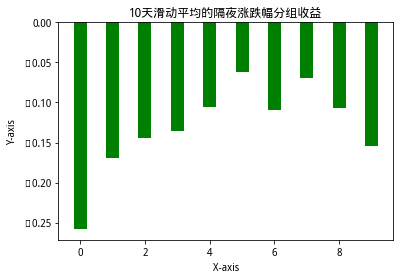

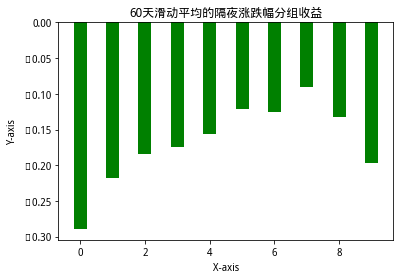

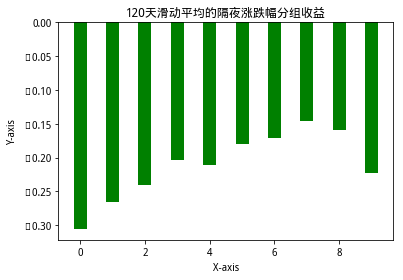

In [7]:
#获取各组收益率统计
group,net_value,return_m = get_group(close,alpharank,alpharank.index,10)
fig = plt.figure()
plt.bar(range(10),list(return_m),0.4,color="green")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("10天滑动平均的隔夜涨跌幅分组收益")

#60日滑动平均收益率观察
mv_jump = jump.rolling(60).mean().iloc[0:].fillna(0).iloc[60:]
mv_jump_monthly = mv_jump.resample('M').last()
alpharank = get_alpharank(mv_jump_monthly,mv_jump_monthly.index)
group,net_value,return_m = get_group(close,alpharank,alpharank.index,10)
fig = plt.figure()
plt.bar(range(10),list(return_m),0.4,color="green")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("60天滑动平均的隔夜涨跌幅分组收益")

#120日滑动平均收益率观察
mv_jump = jump.rolling(120).mean().iloc[0:].fillna(0).iloc[120:]
mv_jump_monthly = mv_jump.resample('M').last()
alpharank = get_alpharank(mv_jump_monthly,mv_jump_monthly.index)
group,net_value,return_m = get_group(close,alpharank,alpharank.index,10)
fig = plt.figure()
plt.bar(range(10),list(return_m),0.4,color="green")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("120天滑动平均的隔夜涨跌幅分组收益")

我们可以得到和研报一样的结论，即我们可以观测到：
1、当因子的参数较小，也即回顾的周期较短的时候，分组收益柱形图明显呈现上凸的形态。这种情况直观的表明， 在短期内，无论隔夜价格变动的方向性如何，当变动幅度较大的时候，未来标的资产的收益表现都欠佳。
2、而当因子参数较大的时候，这种效果被逐渐消失，这表明该因子捕捉的是股票短期的价格特点，时间上可能衰减较快。

## 3.因子的构建与分析
通过上一节的分析可以得出，无论隔夜价格波动的方向性如何，当变动较大时未来收益较小。也就是说，在使用隔夜涨跌幅时，忽略其方向性可能达到更好的效果。于是我们构建了跳空因子，只考虑价格的绝对变动水平。
以$open_t$表示第t日的开盘价， $close_{t−1}$表示第t-1日的收盘价，则第t日的跳空缺口$f_t$表示为如下形式：
\begin{gather}
	f = |open_t / close_{t-1}-1|
\end{gather}

延续前一节， 我们依旧对单个交易日和忽略时间维度的全时间段的因子进行了统计。

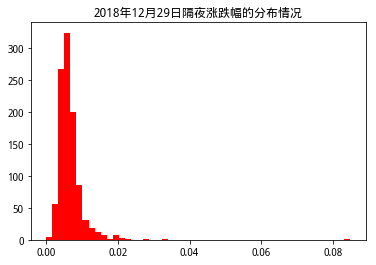

均值，标准差，偏度，峰度,中位数
[0.006655365893669428, 0.0039934662629854244, 8.675774241726334, 0.0023875588464481023, 0.005482327714037727]


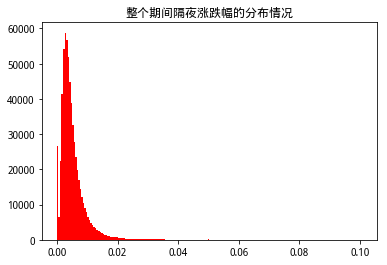

均值，标准差，偏度，峰度，中位数
[0.005128736911269695, 0.004553725294399263, 4.074606299694891, 0.0007776034920950385, '0.0']


In [8]:
#对单个交易日和忽略时间维度的全时间段的因子进行了统计
jump_alpha = pd.DataFrame(abs(multiply(open_p,1/close_p) - 1),columns = open.columns,index = open.index)
alpha = jump_alpha.rolling(10).mean().iloc[0:].fillna(0).iloc[10:]
tem_alpha = list(alpha.iloc[-1])
plt.title("2018年12月29日隔夜涨跌幅的分布情况")
plt.hist(tem_alpha, bins= 50, normed= False, weights= None, cumulative= False, 
         bottom= None, histtype= 'bar', align= 'mid', orientation= 'vertical', rwidth= None, log= False, color= 'r', 
         label='直方图', stacked= False)
plt.show()
print('均值，标准差，偏度，峰度,中位数')
print(calc_stat(tem_alpha))
##统计整个期间隔夜涨跌幅的分布情况
for i in range(0,len(alpha)-1):
    tem_alpha.extend(list(alpha.iloc[i]))
plt.title("整个期间隔夜涨跌幅的分布情况")
plt.hist(tem_alpha, bins= 200, normed= False, weights= None, cumulative= False, 
         bottom= None, histtype= 'bar', align= 'mid', orientation= 'vertical', rwidth= None, log= False, color= 'r', 
         label='直方图', stacked= False)
plt.show()
print('均值，标准差，偏度，峰度，中位数')
print(calc_stat(tem_alpha))


两组数据都明显右偏，且峰度高于正态分布水平，即数据相对集中度较高，分别集中在 0.006左右。也即忽略方向性后，缺口的变动幅度依旧较小，且缺口较大的情况出现的频率较低。

为了初步探知历史跳空因子与未来标的资产收益水平的相关性，每个月末采用历史数据对 10 日（N=10） 跳空因子进行了排序分组，考察下一个月的每组收益情况，具体结果如下：

Text(0.5, 1.0, '因子隔夜涨跌幅分组年化收益')

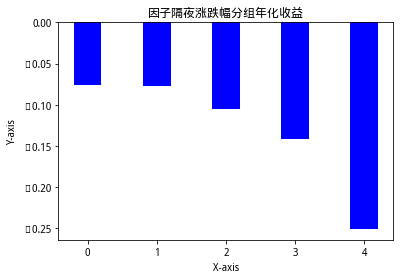

In [9]:
alpha_monthly = alpha.resample('M').last()
alpharank = get_alpharank(alpha_monthly,alpha_monthly.index)
#获取各组收益率统计
group,net_value,return_m = get_group(close,alpharank,alpharank.index,5)
fig = plt.figure()
plt.bar(range(5),list(return_m),0.4,color="blue")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("因子隔夜涨跌幅分组年化收益")


从上图可以看到， 随着因子值的增加， 标的资产未来的收益水平整体呈现一种下降的趋势，也即因子与标的资产未来收益呈现负相关的关系。缺口水平值越大，未来标的资产的收益越不理想。换句话说，
跳空缺口越小的股票，未来收益越高，因子方向为负。

**因子解释：**
从技术形态上解释，涨跌幅的绝对值可以理解为跳空缺口，是 K线图中常见的一种技术图形。俗话说“跳空缺口，逢缺必补”，古老的技术分析的经验，和我们的研究结论是一致的。

从交易行为解释， 跳空缺口的形成其实是短期急切的交易行为导致的。开盘价格异动，和集合竞价成交占比提高、换手率提升、 股价
抬高、成交量相对价格抢跑等特征一样，都反映了股市短期的股价操纵行为，此类反映股票异动、 交易热度提升的因子，短期都具有负向 Alpha。尤其是空头上，短期股票交易过热，负向 Alpha 明显

**因子测试**
本文的回测时间段为 2010 年 01 月 01 日至 2018 年 12 月 29 日，共 2376 个交易日， 108 个月。固定预测期周期为一个月， 因子计算以10天为例，读者可以将其修正为一周，半个月，一个月或一季度。样本空间为全体 A 股，剔除上市未满六个月的新股以及ST股，停牌股等



<Figure size 432x288 with 0 Axes>

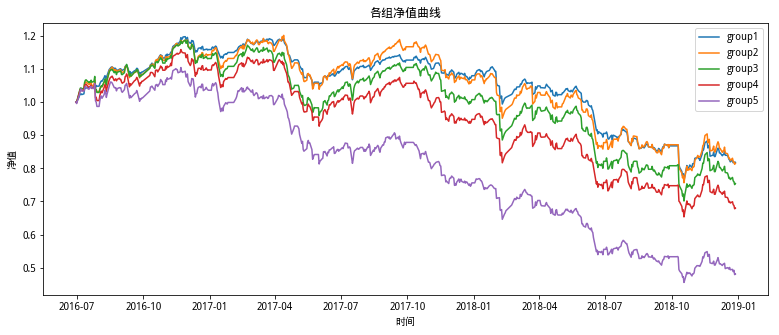

In [10]:
#画出因子分组后不同组的表现
group,net_value,return_m = get_group(close,alpharank,alpharank.index,5)
plt.figure()
fig=plt.figure(figsize=(13,5))
ax1=fig.add_subplot(1,1,1)
for i in range(5):
    ax1.plot(net_value[i],label=u'group'+str(i+1))

ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
plt.legend(loc='best')
plt.xlabel('时间')
plt.ylabel('净值') 
plt.title('各组净值曲线') 
plt.show()

从结果上看第一组和第二组区分度不高，但第五组显著劣于前两组，因子多空分化效果较好。为了进一步确认分组效果，我们画出多空净值曲线。

No handles with labels found to put in legend.


    年化收益率   年化波动率 收益波动比   最大回撤    CR
0  21.13%  10.13%  2.08  6.24%  3.39


<Figure size 432x288 with 0 Axes>

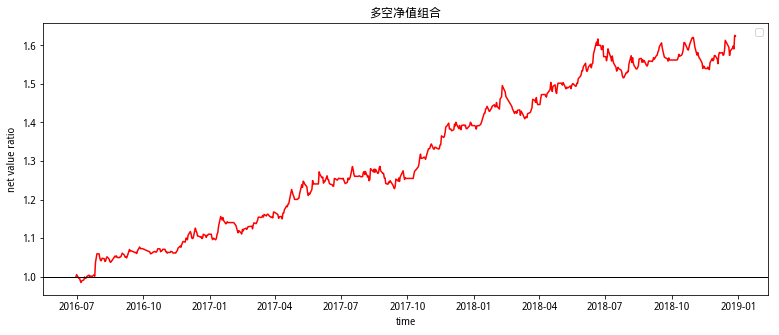

In [11]:
#画出因子多空净值表现
long_short = net_value[0].pct_change() - net_value[4].pct_change()
print(pd.DataFrame(report(long_short)))
(long_short.fillna(0)+1).cumprod()
d = (long_short.fillna(0)+1).cumprod()
plt.figure()
fig=plt.figure(figsize=(13,5))
ax1=fig.add_subplot(1,1,1)
ax1.plot(d,'r')
ax1.axhline(1.0, linestyle='-', color='black', lw=1)
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('net value ratio') 
plt.title('多空净值组合') 
plt.show()

从结果来看， 10 日的跳空因子表现优异，多空分化收益达到 21.14%，最大回撤仅达6.24%。

如果取隔夜收益率的5日滑动平均值作为因子值，可以得到：

<Figure size 432x288 with 0 Axes>

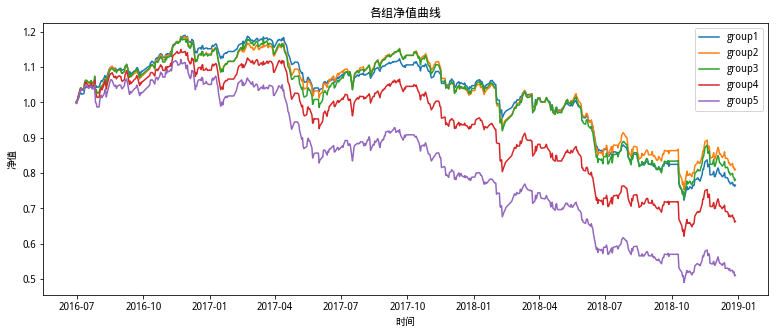

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

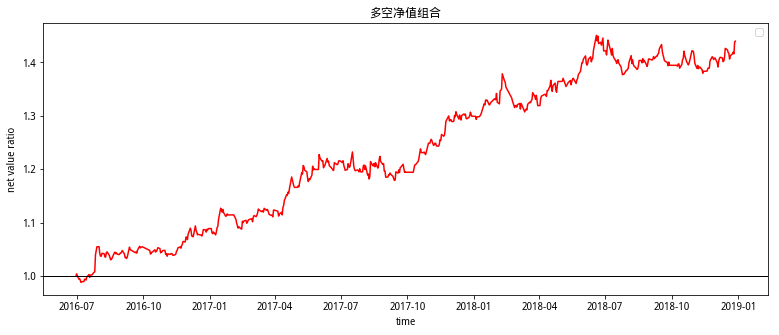

In [12]:
alpha =  jump_alpha.rolling(5).mean().iloc[0:].fillna(0).iloc[5:]
alpha_monthly = alpha.resample('M').last()
alpharank = get_alpharank(alpha_monthly,alpha_monthly.index)
#画出因子分组后不同组的表现
group,net_value,return_m = get_group(close,alpharank,alpharank.index,5)
plt.figure()
fig=plt.figure(figsize=(13,5))
ax1=fig.add_subplot(1,1,1)
for i in range(5):
    ax1.plot(net_value[i],label=u'group'+str(i+1))
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
plt.legend(loc='best')
plt.xlabel('时间')
plt.ylabel('净值') 
plt.title('各组净值曲线') 
plt.show()
#画出因子多空净值表现
long_short = net_value[0].pct_change() - net_value[4].pct_change()

(long_short.fillna(0)+1).cumprod()
d = (long_short.fillna(0)+1).cumprod()
plt.figure()
fig=plt.figure(figsize=(13,5))
ax1=fig.add_subplot(1,1,1)
ax1.plot(d,'r')
ax1.axhline(1.0, linestyle='-', color='black', lw=1)
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('net value ratio') 
plt.title('多空净值组合') 
plt.show()

可见当取隔夜收益率的5日滑动平均值作为因子值时，年化收益率将下降至15.52%。该结果也与研报得出的10日滑动平均值做因子值为较优的结论相匹配。其余用不同期限做滑动平均值的结果限于篇幅，不一一展示，读者有兴趣可自修改代码中的参数。

## 4.常用因子相关性
市值、 换手和动量作为已知的有效常用因子，可能会对新挖掘的因子有一定的影响。 为了探讨跳空因子与上述三个因子的关系，下面分别给出了跳空因子与三个因子的相关系数时间序列的平均值。 

In [13]:
#提取市值因子
df = get_fundamentals(query(
              valuation.circulating_market_cap         
          ).filter(
              # 这里不能使用 in 操作, 要使用in_()函数
              valuation.code.in_(stocks)
          ), date=alpharank.index[0])
df.index = stocks
df.columns = [alpharank.index[0]]
df = df.T
for i in range (1,len(alpharank.index)):
    df_tem = get_fundamentals(query(
              valuation.circulating_market_cap 
          ).filter(
              # 这里不能使用 in 操作, 要使用in_()函数
              valuation.code.in_(stocks)
          ), date=alpharank.index[i])
    df_tem.index = stocks
    df_tem.columns = [alpharank.index[i]]
    df_tem = df_tem.T
    frames = [df, df_tem]
    df = pd.concat(frames)
caprank = get_alpharank(df,df.index)
#求相关性
rele_cap = []
for i in range(len(caprank)):
    rele_cap.append(spearmanr(caprank.iloc[i,:],alpharank.iloc[i,:]).correlation)
print('市值因子相关性均值：',np.mean(rele_cap))

#提取换手率因子
df = get_fundamentals(query(
              valuation.turnover_ratio         
          ).filter(
              # 这里不能使用 in 操作, 要使用in_()函数
              valuation.code.in_(stocks)
          ), date=alpharank.index[0])
df.index = stocks
df.columns = [alpharank.index[0]]
df = df.T
for i in range (1,len(alpharank.index)):
    df_tem = get_fundamentals(query(
              valuation.turnover_ratio 
          ).filter(
              # 这里不能使用 in 操作, 要使用in_()函数
              valuation.code.in_(stocks)
          ), date=alpharank.index[i])
    df_tem.index = stocks
    df_tem.columns = [alpharank.index[i]]
    df_tem = df_tem.T
    frames = [df, df_tem]
    df = pd.concat(frames)
turn_overrank = get_alpharank(df,df.index)
#求换手率因子相关性
rele_tur = []
for i in range(len(caprank)):
    rele_tur.append(spearmanr(turn_overrank.iloc[i,:],alpharank.iloc[i,:]).correlation)
print('换手率因子相关性均值：',np.mean(rele_tur))
#求动量因子
close_monthly = close.resample('M').last()
close_r_m = close_monthly.pct_change(periods=1)
df_tem = pd.concat([close_r_m,alpharank],join = 'inner',axis = 1)
n = int(len(df_tem.columns)/2)
close_r_m = df_tem.iloc[:,0:n]
alpharank_tem = df_tem.iloc[:,n:]
momrank = get_alpharank(close_r_m,close_r_m.index)
#求动量因子相关性
rele_mom = []
for i in range(len(caprank)):
    rele_mom.append(spearmanr(momrank.iloc[i,:],alpharank.iloc[i,:]).correlation)
print('动量因子相关性均值：',np.mean(rele_mom))

市值因子相关性均值： 0.0019507350185753545
换手率因子相关性均值： 0.01154530387755446
动量因子相关性均值： -0.0027532987355235227


可以看出这三个常见的因子与隔夜价格变动因子的相关性平均值都很低，甚至为负数，表明隔夜价格变动因子是较为有效的。

## 5.因子变形
为了进一步挖掘隔夜价格变动所带来的信号，我们考虑将因子加以改变，以谋求更好的效果。而因子可能的一个变形是计算个股开盘涨跌幅与均值的距离替代与 0 的距离， 这个变形考虑到受市场行情影响，股票可能会有系统性的高开或者低开的情况。以$open_t$表示第t日的开盘价， $close_{t−1}$表示第t-1日的收盘价，则第 t 日的跳空缺口$New_t$表示为如下形式：


\begin{gather}
	New_t = |open_t / close_{t-1}-\overline{f_t}-1|
\end{gather}


为了便于考察不同时间段的缺口，对未来标的资产价格的影响，$\overline{f_t}$采用过去 N 天的$f_t$计算其算术平均作为分析的对象。鉴于该因子变形在不同参数上改进效果不稳健，暂不采用这种算法。在这里我们提供$\overline{f_t}$采用过去 20 天的$f_t$计算其算术平均作为分析的对象的因子计算方法，读者可自行更改。

<Figure size 432x288 with 0 Axes>

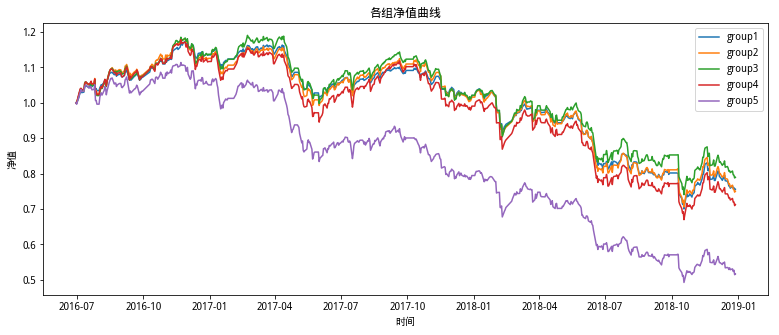

No handles with labels found to put in legend.


    年化收益率  年化波动率 收益波动比   最大回撤    CR
0  14.81%  7.63%  1.94  5.03%  2.94


<Figure size 432x288 with 0 Axes>

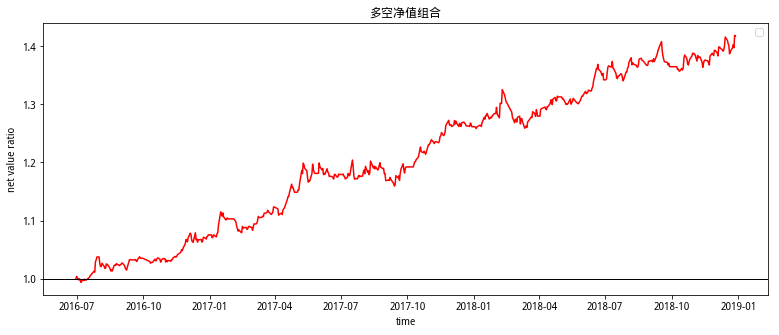

In [14]:
#构建因子的变形
alpha_20 = jump_alpha.rolling(20).mean().iloc[0:].fillna(0)
new_alpha = pd.DataFrame(abs(multiply(open_p,1/close_p) - alpha_20 - 1),columns = open.columns,index = open.index)
new_alpha_monthly = new_alpha.resample('M').last()
new_alpharank = get_alpharank(new_alpha_monthly,new_alpha_monthly.index)
#测试因子变后的效果
group,net_value,return_m = get_group(close,new_alpharank,new_alpharank.index,5)
plt.figure()
fig=plt.figure(figsize=(13,5))
ax1=fig.add_subplot(1,1,1)
for i in range(5):
    ax1.plot(net_value[i],label=u'group'+str(i+1))

ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
plt.legend(loc='best')
plt.xlabel('时间')
plt.ylabel('净值') 
plt.title('各组净值曲线') 
plt.show()
#画出因子变形后多空表现
long_short = net_value[0].pct_change() - net_value[4].pct_change()
print(pd.DataFrame(report(long_short)))
(long_short.fillna(0)+1).cumprod()
d = (long_short.fillna(0)+1).cumprod()
plt.figure()
fig=plt.figure(figsize=(13,5))
ax1=fig.add_subplot(1,1,1)
ax1.plot(d,'r')
ax1.axhline(1.0, linestyle='-', color='black', lw=1)
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('net value ratio') 
plt.title('多空净值组合') 
plt.show()

可以看出我们采取的因子变形所带来的提升并不明显，甚至导致多空组合年化收益率下降，因此暂不考虑该种因子变形的方法。

## 6.因子在指数上适用性
前文我们对 A 股全市场做了关于跳空因子的测试，测试结果表明该因子具有一定的有效性。 那么当股票集合变动，这种有效性是否可以延续呢？ 本节对常用的两个指数沪深 300 和 中证 500 成分股进行了相应的测试。

首先是因子在沪深300上的表现：



/opt/conda/lib/python3.6/site-packages/jqresearch/api.py:86: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  pre_factor_ref_date=_get_today())


<Figure size 432x288 with 0 Axes>

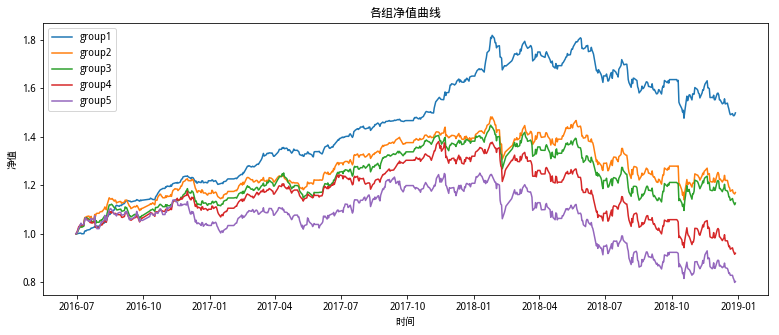

No handles with labels found to put in legend.


    年化收益率   年化波动率 收益波动比   最大回撤    CR
0  24.86%  13.69%  1.82  9.67%  2.57


<Figure size 432x288 with 0 Axes>

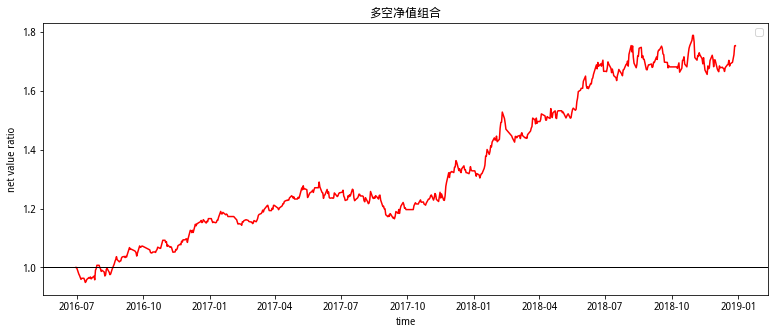

In [15]:
#提取沪深300的数据
stocks = list(get_index_stocks('000300.XSHG'))
data = get_price(stocks, start_date=start, end_date=end, frequency='daily', fields=None, skip_paused=False, fq='pre')
open = data.loc['open'].iloc[1:]
close = data.loc['close']
close = close.fillna(0)
for i in range(len(close.columns)):
    array = np.array(close.iloc[:,i])
    p = array[-1]
    for j in range(len(array)):
        if array[len(array)-j-1] != 0:
            p = array[len(array)-j-1]
        else:
            array[len(array)-j-1] = p
    close.iloc[:,i] = array
close_p = np.array(data.loc['close'].iloc[0:-1])
open_p = np.array(data.loc['open'].iloc[1:])
#构建因子
jump_alpha = pd.DataFrame(abs(multiply(open_p,1/close_p) - 1),columns = open.columns,index = open.index)
alpha = jump_alpha.rolling(10).mean().iloc[10:].fillna(0)
alpha_monthly = alpha.resample('M').last()
alpharank = get_alpharank(alpha_monthly,alpha_monthly.index)
#获得因子分组净值曲线
group,net_value,return_m = get_group(close,alpharank,alpharank.index,5)
plt.figure()
fig=plt.figure(figsize=(13,5))
ax1=fig.add_subplot(1,1,1)
for i in range(5):
    ax1.plot(net_value[i],label=u'group'+str(i+1))

ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
plt.legend(loc='best')
plt.xlabel('时间')
plt.ylabel('净值') 
plt.title('各组净值曲线') 
plt.show()
#获得多空净值曲线
long_short = net_value[0].pct_change() - net_value[4].pct_change()
print(pd.DataFrame(report(long_short)))
(long_short.fillna(0)+1).cumprod()
d = (long_short.fillna(0)+1).cumprod()
plt.figure()
fig=plt.figure(figsize=(13,5))
ax1=fig.add_subplot(1,1,1)
ax1.plot(d,'r')
ax1.axhline(1.0, linestyle='-', color='black', lw=1)
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('net value ratio') 
plt.title('多空净值组合') 
plt.show()


可见隔夜价格变动因子在沪深300上依然表现出色，年化收益率约为25%，最大回撤控制在10%以内。

其次我们检查因子在中证500上的表现：

<Figure size 432x288 with 0 Axes>

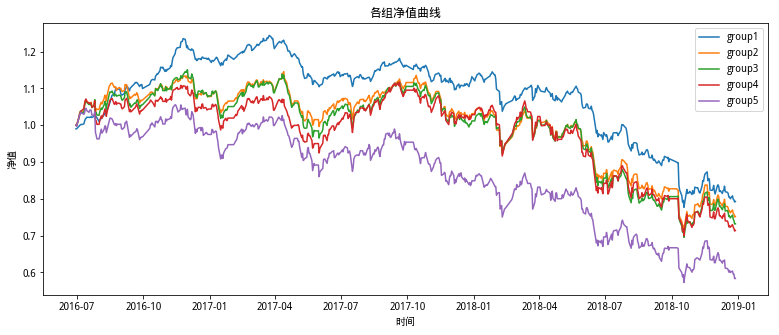

    年化收益率   年化波动率 收益波动比    最大回撤   CR
0  10.59%  13.03%  0.81  13.17%  0.8


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

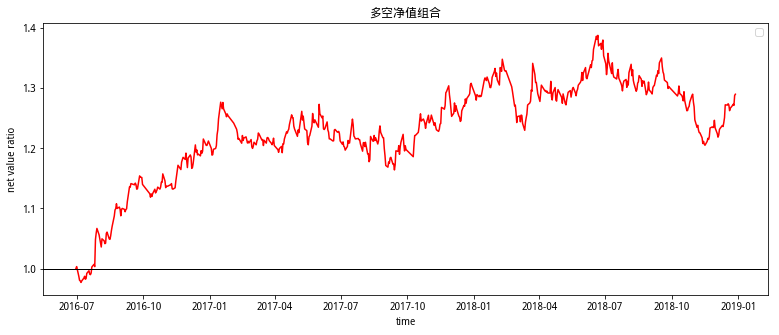

In [16]:
#提取中证500的数据
stocks = list(get_index_stocks('000905.XSHG'))
#stocks = delect_stock(list(stocks),start)
data = get_price(stocks, start_date=start, end_date=end, frequency='daily', fields=None, skip_paused=False, fq='pre')
open = data.loc['open'].iloc[1:]
close = data.loc['close']
close = close.fillna(0)
for i in range(len(close.columns)):
    array = np.array(close.iloc[:,i])
    p = array[-1]
    for j in range(len(array)):
        if array[len(array)-j-1] != 0:
            p = array[len(array)-j-1]
        else:
            array[len(array)-j-1] = p
    close.iloc[:,i] = array
#close = data.loc['close']
close_p = np.array(data.loc['close'].iloc[0:-1])
open_p = np.array(data.loc['open'].iloc[1:])
#构建因子
jump_alpha = pd.DataFrame(abs(multiply(open_p,1/close_p) - 1),columns = open.columns,index = open.index)
alpha = jump_alpha.rolling(10).mean().iloc[0:].fillna(0).iloc[10:] 
alpha_monthly = alpha.resample('M').last()
alpharank = get_alpharank(alpha_monthly,alpha_monthly.index)
#获得因子分组净值曲线
group,net_value,return_m = get_group(close,alpharank,alpharank.index,5)
plt.figure()
fig=plt.figure(figsize=(13,5))
ax1=fig.add_subplot(1,1,1)
for i in range(5):
    ax1.plot(net_value[i],label=u'group'+str(i+1))

ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
plt.legend(loc='best')
plt.xlabel('时间')
plt.ylabel('净值') 
plt.title('各组净值曲线') 
plt.show()
#获得多空净值曲线
long_short = net_value[0].pct_change() - net_value[4].pct_change()
print(pd.DataFrame(report(long_short)))
(long_short.fillna(0)+1).cumprod()
d = (long_short.fillna(0)+1).cumprod()
plt.figure()
fig=plt.figure(figsize=(13,5))
ax1=fig.add_subplot(1,1,1)
ax1.plot(d,'r')
ax1.axhline(1.0, linestyle='-', color='black', lw=1)
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('net value ratio') 
plt.title('多空净值组合') 
plt.show()


从因子在指数应用的结果来看，隔夜价格变动因子在沪深300取得了十分优秀的表现，多空净值曲线的年化均超过了20%，最大回撤控制在了10%以内。但在中证500上近几年因子的表现较为平庸，多空净值年化仅为10.59%。

## 7.结论
传统的动量/反转因子只计算区间股价的起点与终点之间的位移，而忽略了股价跌宕起伏的漫长旅途中所发生的故事。这其中颇为精彩的一段是隔夜，用来描述股价开盘和前收盘，一天中最关键的两个时间节点之间的偏离。本研究发现在选股上，隔夜涨跌幅因子既不呈现反转也不呈现动量， 过大或者过小在后一月都具有负向收益， 我们引入隔夜涨跌幅的绝对值来衡量这股市上述的这种隔夜跳空异动的现象。

通过研报构建的因子，我们可以在全A股和沪深300都取得十分优异的表现，多空年化均超过20%，但近几年在中证500表现较差，多空年化仅为10%左右。

**未来展望**：
研究结果为我们提供了一定的思考方向，即对隔夜价格变动因子的构建以及如何做进一步的改进提供了思路。如何将隔夜价格变动因子进行修改将是我们接下来的工作。同时本篇报告并没有将换手因素加入，即没有考虑交易费用所带来的影响。这都是之后值得研究的问题。